# Roberta model construction with EA

2020/11/30

Student: Xuanyu Su                                                                 
Supervisor: Isar Nejadgholi

in this module, we use EA data to train a Roberta model and test 2400 covid data on it



In [45]:
pip install transformers

In [46]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup

import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

# Set random seed and set device to GPU.
torch.manual_seed(17)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')

print(device)

cuda:0


In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
# Initialize tokenizer.
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [49]:
source_folder = 'Data'
destination_folder = 'Model'

In [54]:
import pandas as pd
EA_train = pd.read_csv('/content/drive/MyDrive/EAtrain.csv',sep = ',', encoding = "ISO-8859-1")
EA_val = pd.read_csv('/content/drive/MyDrive/EAvalid.csv',sep = ',', encoding = "ISO-8859-1")
EA_test = pd.read_csv('/content/drive/MyDrive/EAtest.csv',sep = ',', encoding = "ISO-8859-1")

In [9]:
EA_test.head()

,text,hate
0,they are coming in all directions fxxk jan 27...,1
1,ap zkaram evil eastasia china and chinese spr...,1
2,the corruption within eastasia is serious som...,1
3,ummmmm why do not use eastasia virus or east...,0
4,wildthang1471 personally i believe the chinese...,1


In [11]:
EA_train['hate'] = EA_train['hate'].astype(int)
EA_val['hate'] = EA_val['hate'].astype(int)
EA_test['hate'] = EA_test['hate'].astype(int)

In [13]:
EA_train.to_csv('Data/Train_EA.csv',index=False,header=True)
EA_val.to_csv('Data/Val_EA.csv',index=False,header=True)
EA_test.to_csv('Data/Test_EA.csv',index=False,header=True)

In [14]:
# Model parameter
MAX_SEQ_LEN = 128
BATCH_SIZE = 8
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True)
text_field = Field(use_vocab=False, 
                   tokenize=tokenizer.encode, 
                   include_lengths=False, 
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, 
                   unk_token=UNK_INDEX)
fields = [('text', text_field),('hate', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='Train_EA.csv', validation='Val_EA.csv',
                                           test='Test_EA.csv', format='CSV', fields=fields, skip_header=True)


train_iter_EA = BucketIterator(train, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter_EA = BucketIterator(valid, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter_EA = Iterator(test, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [15]:
# Functions for saving and loading model parameters and metrics.
def save_checkpoint(path, model, valid_loss):
    torch.save({'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}, path)

    
def load_checkpoint(path, model):    
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict['model_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(path, train_loss_list, valid_loss_list, global_steps_list):   
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, path)


def load_metrics(path):    
    state_dict = torch.load(path, map_location=device)
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [16]:
# Model with extra layers on top of RoBERTa
class ROBERTAClassifier(torch.nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ROBERTAClassifier, self).__init__()
        
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(768, 64)
        self.bn1 = torch.nn.LayerNorm(64)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l2 = torch.nn.Linear(64, 2)
        
    def forward(self, input_ids, attention_mask):
        _, x = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        x1 = self.d1(x)
        x2 = self.l1(x1)
        x3 = self.bn1(x2)
        x4 = torch.nn.Tanh()(x3)
        x5 = self.d2(x4)
        x6 = self.l2(x5)
        
        return x6

In [20]:
def pretrain(model, 
             optimizer, 
             train_iter, 
             valid_iter, 
             scheduler = None,
             valid_period = len(train_iter_EA),
             num_epochs = 5):
    
    # Pretrain linear layers, do not train bert
    for param in model.roberta.parameters():
        param.requires_grad = False
    
    model.train()
    
    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0   
    global_step = 0  
    
    # Train loop
    for epoch in range(num_epochs):
        count = 0
        for (source, target), _ in train_iter:
            mask = (source != PAD_INDEX).type(torch.uint8)
        
            y_pred = model(input_ids=source,  
                           attention_mask=mask)
            
            loss = torch.nn.CrossEntropyLoss()(y_pred, target)
            print('batch_no [{}/{}]:'.format(count, int(len(train_iter_EA)/BATCH_SIZE)),'training_loss:',loss)
            count+=1
            loss.backward()
            
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()
                
                with torch.no_grad():                    
                    for (source, target), _ in valid_iter:
                        mask = (source != PAD_INDEX).type(torch.uint8)
                        
                        y_pred = model(input_ids=source, 
                                       attention_mask=mask)
                        
                        loss = torch.nn.CrossEntropyLoss()(y_pred, target)
                        
                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)
                
                model.train()

                # print summary
                print('Epoch [{}/{}], global step [{}/{}], PT Loss: {:.4f}, Val Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              train_loss, valid_loss))
                
                train_loss = 0.0                
                valid_loss = 0.0
    
    # Set bert parameters back to trainable
    for param in model.roberta.parameters():
        param.requires_grad = True
        
    print('Pre-training done!')

In [21]:
# Training Function
output_path = 'Model'
def train(model,
          optimizer,
          train_iter,
          valid_iter,
          scheduler = None,
          num_epochs = 5,
          valid_period = len(train_iter_EA),
          output_path = output_path):
    
    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0
    train_loss_list = []
    valid_loss_list = []
    best_valid_loss = float('Inf')
    
    global_step = 0
    global_steps_list = []
    
    model.train()
    
    # Train loop
    for epoch in range(num_epochs):
        count = 0
        for (source, target), _ in train_iter:
            
            mask = (source != PAD_INDEX).type(torch.uint8)

            y_pred = model(input_ids=source,  
                           attention_mask=mask)

            loss = torch.nn.CrossEntropyLoss()(y_pred, target)
            #loss = output[0]
            print('batch_no [{}/{}]:'.format(count, int(len(train_iter_EA)/BATCH_SIZE)),'training_loss:',loss)
            count+=1
            loss.backward()
            
            
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()
                
                with torch.no_grad():                    
                    for (source, target), _ in valid_iter:
                        mask = (source != PAD_INDEX).type(torch.uint8)

                        y_pred = model(input_ids=source, 
                                       attention_mask=mask)

                        
                        loss = torch.nn.CrossEntropyLoss()(y_pred, target)

                        
                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)
                train_loss_list.append(train_loss)
                valid_loss_list.append(valid_loss)
                global_steps_list.append(global_step)

                # print summary
                print('Epoch [{}/{}], global step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              train_loss, valid_loss))
                
                # checkpoint
                if best_valid_loss > valid_loss:
                    best_valid_loss = valid_loss
                    save_checkpoint(output_path + '/model.pkl', model, best_valid_loss)
                    save_metrics(output_path + '/metric.pkl', train_loss_list, valid_loss_list, global_steps_list)
                        
                train_loss = 0.0                
                valid_loss = 0.0
                model.train()
    
    save_metrics(output_path + '/metric.pkl', train_loss_list, valid_loss_list, global_steps_list)
    print('Training done!')

In [22]:
# Main training loop
NUM_EPOCHS = 2
steps_per_epoch = len(train_iter_EA)

model = ROBERTAClassifier(0.3)
model = model.to(device)

print("======================= Start pretraining ==============================")



optimizer = AdamW(model.parameters(), lr=1e-4)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*1, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)
pretrain(model=model,
         train_iter=train_iter_EA,
         valid_iter=valid_iter_EA,
         optimizer=optimizer,
         scheduler=scheduler,
         num_epochs=NUM_EPOCHS)

NUM_EPOCHS = 3
print("======================= Start training =================================")
optimizer = AdamW(model.parameters(), lr=2e-6)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*2, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)

train(model=model, 
      train_iter=train_iter_EA, 
      valid_iter=valid_iter_EA, 
      optimizer=optimizer, 
      scheduler=scheduler, 
      num_epochs=NUM_EPOCHS)

Streaming output truncated to the last 5000 lines.
batch_no [1004/250]: training_loss: tensor(0.5296, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1005/250]: training_loss: tensor(0.5891, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1006/250]: training_loss: tensor(0.3657, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1007/250]: training_loss: tensor(0.6648, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1008/250]: training_loss: tensor(0.3850, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1009/250]: training_loss: tensor(0.4925, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1010/250]: training_loss: tensor(0.7466, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1011/250]: training_loss: tensor(0.4771, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1012/250]: training_loss: tensor(0.4523, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1013/250]: training_loss: tensor(0.3404, device='cuda:0', grad_fn=<NllLossBackward>)

In [26]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
# Evaluation Function
import seaborn as sns
def evaluate(model, test_loader):
    y_pred = []
    y_true = []
    y_prob = []
    model.eval()
    with torch.no_grad():
        for (source, target), _ in test_loader:
                mask = (source != PAD_INDEX).type(torch.uint8)
                
                output = model(source, attention_mask=mask)
                y_prob.extend(output.tolist())
                y_pred.extend(torch.argmax(output, axis=-1).tolist())
                y_true.extend(target.tolist())
    
    label_true = []
    for i in y_true:
        if i == 1:
            label_true.append([1,0])
        else:
            label_true.append([0,1])
    y_prob_final = []
    for i in range(len(y_prob)):
        tempA = abs(y_prob[i][0])
        tempB = abs(y_prob[i][1])
        y_prob_final.append(tempA/(tempA+tempB))

    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    plt.figure(1, figsize=(20,8))

    ax= plt.subplot(121)
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(['Attack', 'Not attack'])
    ax.yaxis.set_ticklabels(['Attack', 'Not attack'])
    fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_true, y_prob_final)
    plt.subplot(122)
    lw = 2
    plt.plot(fpr_rt_lm, tpr_rt_lm, color='darkorange',
             lw=lw, label='roc curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid()
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

Classification Report:
              precision    recall  f1-score   support

           1     0.7488    0.8824    0.8101       527
           0     0.9550    0.8941    0.9236      1473

    accuracy                         0.8910      2000
   macro avg     0.8519    0.8882    0.8668      2000
weighted avg     0.9007    0.8910    0.8937      2000



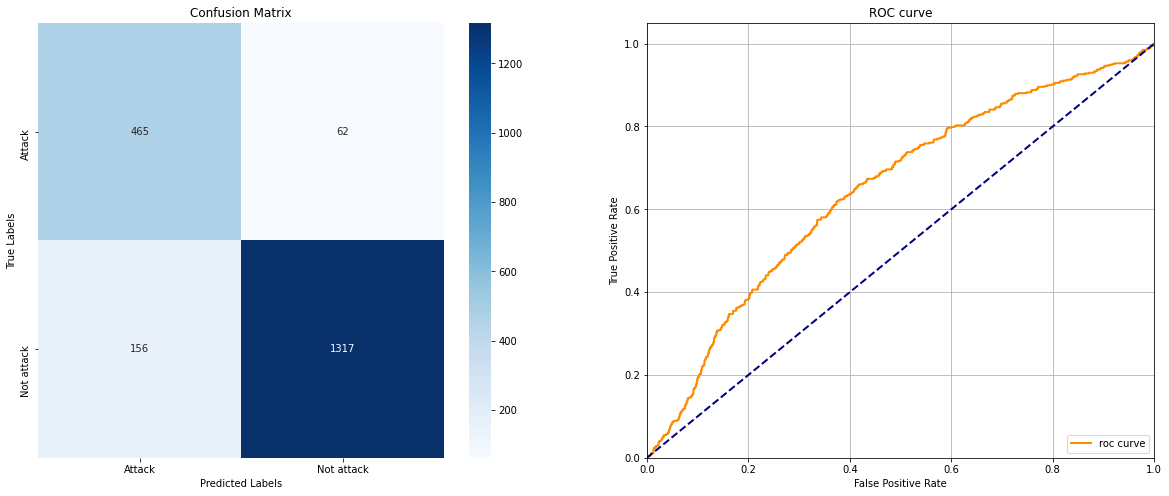

In [27]:
evaluate(model, test_iter_EA)

# Test in 2400 Covid

In [55]:
test_data2400 = pd.read_csv('Data/test5.csv',sep=',',encoding = "ISO-8859-1")

In [56]:
test_data2400.head()

,comment,attack
0,fucking piece of shit your whole community is...,1.0
1,im not being funny but coronavirus in china ir...,0.0
2,got on the victoria line today to seven sister...,1.0
3,it s appalling that the media amp libtards bit...,1.0
4,dude fuck the chinese man fuck em and if you t...,1.0


In [57]:
test_data2400['attack'] = [int(i) for i in test_data2400['attack']]

In [66]:
# Model parameter
MAX_SEQ_LEN = 80
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('text', text_field),('hate', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='test5.csv', validation='test5.csv',
                                           test='test5.csv', format='CSV', fields=fields, skip_header=True)

test_iter_2400 = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

Classification Report:
              precision    recall  f1-score   support

           1     0.6142    0.7419    0.6720       678
           0     0.8833    0.8074    0.8437      1641

    accuracy                         0.7883      2319
   macro avg     0.7487    0.7747    0.7578      2319
weighted avg     0.8046    0.7883    0.7935      2319



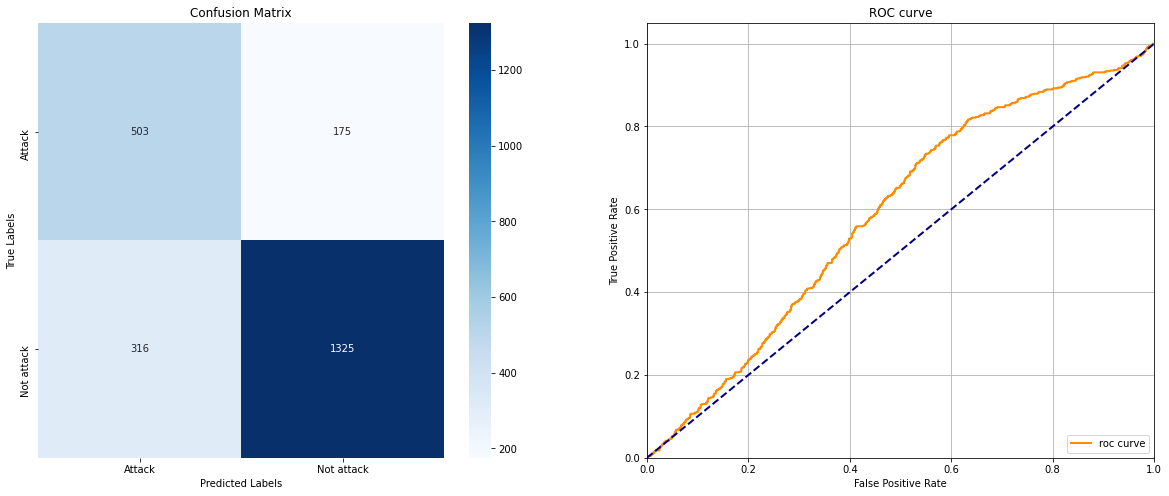

TypeError: ignored

In [67]:
y_true, y_pred,y_prob = evaluate(model, test_iter_2400)